# 1 Author
Name: Neeraj Yadav <br>


# 2 Problem Formulation
Building a machine learning pipeline, using the MILE END Sounds Data Set, which takes as input an audio segment and predicts the area where that segment was recorded. In the given data set, there are six areas namely 'Euston', 'british', 'campus', 'kensington', 'southbank' and 'westend'.

# 3 Machine Learning Pipeline
1: Loading Data and Identifying Labels - The Dataset provided in MS Teams is uploaded to Google Drive. Based on the email correspondence, 6 files numbered 0033, 0381, 2201, 2203, 2205 and 2206 are removed as these files are corrupt. Then, all of the files (2494 in total) are analyzed for classifying labels. <br>
2: Feature Extraction - For the basic solution, the audio files are read and features power, pitch mean, pitch standard deviation, fraction of voiced region, spectral centroid, spectral bandwidth, spectral contrast and mfcc are extracted. <br>
3: Pipeline Modelling - The data are standardized and the machine learning model is implemented. <br>
3: Training/Analysis 
4: Validation/Analysis

We are using some of the code from the starter kit to set up data and process it.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

In [23]:
sample_path = r'C:\Users\venkataramanan\Downloads\ml\ml\*.wav'
files = glob.glob(sample_path)
len(files)

2494

In [24]:
MLENDLS_df = pd.read_csv(r'C:\Users\venkataramanan\Downloads\ml\MLEndLS.csv').set_index('file_id')
MLENDLS_df.head()

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176


# 4 Feature extraction

We extract the following features from the audio dataset. <br>
1.   Power. <br>
2.   Pitch - mean. <br>
3.   Pitch - standard deviation. <br>
4.   Fraction of voiced region. <br>
5.   Spectral Centrroid <br>
6.   Spectral Bandwidth <br>
7.   Spectral Contrast <br>
8.   Chromagram <br>
9.   Constant-Q chromagram <br>
10.  Chroma variant “Chroma Energy Normalized” (CENS) <br>
11.  Mel-frequency cepstral coefficients (MFCC) <br>
We find the mean of these features. And, these features are appended to the list X (predictors). The label y in this case is binary i.e., 0 corresponds to outdoors and 1 corresponds to indoors.

In [25]:
#pitch of an audio signal
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [26]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('\\')[-1]
    file_name = file.split('\\')[-1]
    yi = labels_file.loc[fileID]['area']

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    spectral_centroid=np.mean(librosa.feature.spectral_centroid(y=x,sr=fs))
    spectral_bandwidth=np.mean(librosa.feature.spectral_bandwidth(y=x,sr=fs))
    spectral_contrast=np.mean(librosa.feature.spectral_contrast(y=x,sr=fs))
    chroma_stft=np.mean(librosa.feature.chroma_stft(y=x,sr=fs))
    chroma_cqt=np.mean(librosa.feature.chroma_cqt(y=x,sr=fs))
    chroma_cens=np.mean(librosa.feature.chroma_cens(y=x,sr=fs))
    mfcc=np.mean(librosa.feature.mfcc(y=x,sr=fs))
    xi = [power,pitch_mean,pitch_std,voiced_fr,spectral_centroid,spectral_bandwidth,spectral_contrast,chroma_stft,chroma_cqt,chroma_cens,mfcc]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [27]:
X,y = getXy(files, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

 83%|████████▎ | 2068/2494 [51:47<09:47,  1.38s/it] C:\Users\venkataramanan\.conda\envs\machine-learning-env\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=889
  return f(*args, **kwargs)
100%|██████████| 2494/2494 [1:02:18<00:00,  1.50s/it]


In [35]:
print(y)

['british' 'kensington' 'campus' ... 'westend' 'british' 'british']


In [29]:
#Save the outputs to use later
np.save('X.npy', X)
np.save('y.npy', y)

# 5 Methodology

Following methodology has ben used to build the model. <br>

1.   train_test_split: Data are split in 7:3 proportion for training and validation <br>
2.   Standard Scaler: z-score normalization is applied on the data so that no feature with large range of values dominates algorithms <br>
3.   Using GridSearchCV we find optimal parameters for our models
4.   We use validation accuracy and other metrics like precision, recall, f1-score, confusion matrix and ROC AUC to determine which performs better.

# 6 Normalizing and Visualizing Dataset
Before any machine learning model is implemented, it is imperative that the data are standardized. We can perform this using the StandardScaler class.

In [ ]:
#Load the outputs
X=np.load('X_basic.npy')
y=np.load('Y_basic.npy')

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

s = StandardScaler()
X = s.fit_transform(X)
MLENDLS_df_features = pd.DataFrame(data=X, columns=['power','pitch_mean','pitch_std','voiced_fr','spectral_centroid','spectral_bandwidth','spectral_contrast','chroma_stft','chroma_cqt','chroma_cens','mfcc'])
MLENDLS_df_features['class'] = y
enc = LabelEncoder() 
MLENDLS_df_features["Target"] = enc.fit_transform(MLENDLS_df_features["class"])
MLENDLS_df_features['fileId'] = [file.split('\\')[-1] for file in files if file.split('\\')[-1] in MLENDLS_df.index]
MLENDLS_df_features.to_csv('MileEnd_DF_Advanced_Features.csv')

In [40]:
MLENDLS_df_features.head()

,power,pitch_mean,pitch_std,voiced_fr,spectral_centroid,spectral_bandwidth,spectral_contrast,chroma_stft,chroma_cqt,chroma_cens,mfcc,class,Target,fileId
0,1.270302,-0.840896,-0.880589,-0.855506,0.969704,1.079002,-0.246406,2.014041,-1.407725,-0.817429,1.918493,british,1,0001.wav
1,-0.312658,0.512150,0.626709,0.576658,-0.596170,-0.537630,0.806245,-0.925447,0.594139,0.476716,-0.519981,kensington,3,0002.wav
2,-0.738572,-0.439507,-0.382258,-0.389923,0.501195,0.270155,-0.619752,1.038037,1.061882,0.503472,0.140253,campus,2,0003.wav
3,0.286235,-0.321508,-0.144265,0.261876,0.516629,0.847039,-0.322517,-0.626912,0.664916,0.959727,-0.476240,kensington,3,0004.wav
4,-1.070913,0.098149,0.207105,-0.221206,-0.238468,-0.689238,-0.697768,0.592218,1.137551,0.700249,-1.737288,campus,2,0005.wav


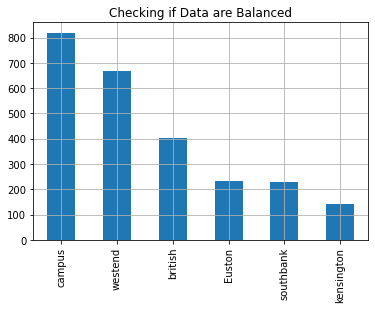

In [38]:
MLENDLS_df_features['class'].value_counts().plot(kind='bar')
plt.title('Checking if Data are Balanced')
plt.grid()
plt.show()

As we observe, the proportion of data in each class corresponding to a particular area is not balanced. They are disproportionate. 

# 7 Principal Component Analysis
Since number of features is 11, we can try and do dimensionality reduction and check whether maximum variance is captured. If so, we can build our models on these reduced dimensions. We try with 2, 4 and 6 components.

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
df_pca1 = pd.DataFrame(pca.transform(X), columns=['pca_1','pca_2'], index=MLENDLS_df_features.index)
print("Cumulative Explained Variance Ratio for 2 Components")
print(pca.explained_variance_ratio_.cumsum())
pca = PCA(n_components=4)
pca.fit(X)
df_pca2 = pd.DataFrame(pca.transform(X), columns=['pca_1','pca_2','pca_3','pca_4'], index=MLENDLS_df_features.index)
print("Cumulative Explained Variance Ratio for 4 Components")
print(pca.explained_variance_ratio_.cumsum())
pca = PCA(n_components=6)
pca.fit(X)
print("Cumulative Explained Variance Ratio for 6 Components")
print(pca.explained_variance_ratio_.cumsum())
df_pca3 = pd.DataFrame(pca.transform(X), columns=['pca_1','pca_2','pca_3','pca_4','pca_5','pca_6'], index=MLENDLS_df_features.index)

Cumulative Explained Variance Ratio for 2 Components
[0.25637353 0.47267654]
Cumulative Explained Variance Ratio for 4 Components
[0.25637353 0.47267654 0.62739203 0.73741792]
Cumulative Explained Variance Ratio for 6 Components
[0.25637353 0.47267654 0.62739203 0.73741792 0.8239052  0.87283697]


Reducing features to two components only captures approximately 47 percent of the total variance. Comparatively, 6 components does better as total variance captured is approximately 87 percent.

Even with six components total explained variance is not satisfactory to justify dimensionality reduction using PCA.

# 8 Visualizing Data

In [93]:
import seaborn as sns
df_total = MLENDLS_df_features.copy(deep=True)
df_total

,power,pitch_mean,pitch_std,voiced_fr,spectral_centroid,spectral_bandwidth,spectral_contrast,chroma_stft,chroma_cqt,chroma_cens,mfcc,class,Target,fileId
0,1.270302,-0.840896,-0.880589,-0.855506,0.969704,1.079002,-0.246406,2.014041,-1.407725,-0.817429,1.918493,british,1,0001.wav
1,-0.312658,0.512150,0.626709,0.576658,-0.596170,-0.537630,0.806245,-0.925447,0.594139,0.476716,-0.519981,kensington,3,0002.wav
2,-0.738572,-0.439507,-0.382258,-0.389923,0.501195,0.270155,-0.619752,1.038037,1.061882,0.503472,0.140253,campus,2,0003.wav
3,0.286235,-0.321508,-0.144265,0.261876,0.516629,0.847039,-0.322517,-0.626912,0.664916,0.959727,-0.476240,kensington,3,0004.wav
4,-1.070913,0.098149,0.207105,-0.221206,-0.238468,-0.689238,-0.697768,0.592218,1.137551,0.700249,-1.737288,campus,2,0005.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,1.831206,-0.277580,-0.591740,-0.802402,-0.198710,0.337320,-0.513777,1.756816,0.427919,-0.045635,1.969909,westend,5,2496.wav
2490,0.088305,0.968655,0.940637,0.245588,0.581187,0.550114,-0.214997,0.034978,0.162492,0.464386,0.735809,campus,2,2497.wav
2491,-0.467235,-0.397159,-0.544029,-0.051873,-0.220644,0.084865,-1.318416,0.451270,0.509259,0.372139,0.249569,westend,5,2498.wav
2492,-0.859817,-0.037203,-0.438539,0.036010,0.276231,0.763763,-0.908782,-1.149133,0.174175,0.061354,-0.775203,british,1,2499.wav


In [94]:
df_total=df_total.drop('class',axis=1)
df_total=df_total.drop('fileId',axis=1)

In [99]:
arr = df_total.to_numpy()
arr = s.fit_transform(arr)
arr = pd.DataFrame(data=arr, columns=['power','pitch_mean','pitch_std','voiced_fr','spectral_centroid','spectral_bandwidth','spectral_contrast','chroma_stft','chroma_cqt','chroma_cens','mfcc','y'])

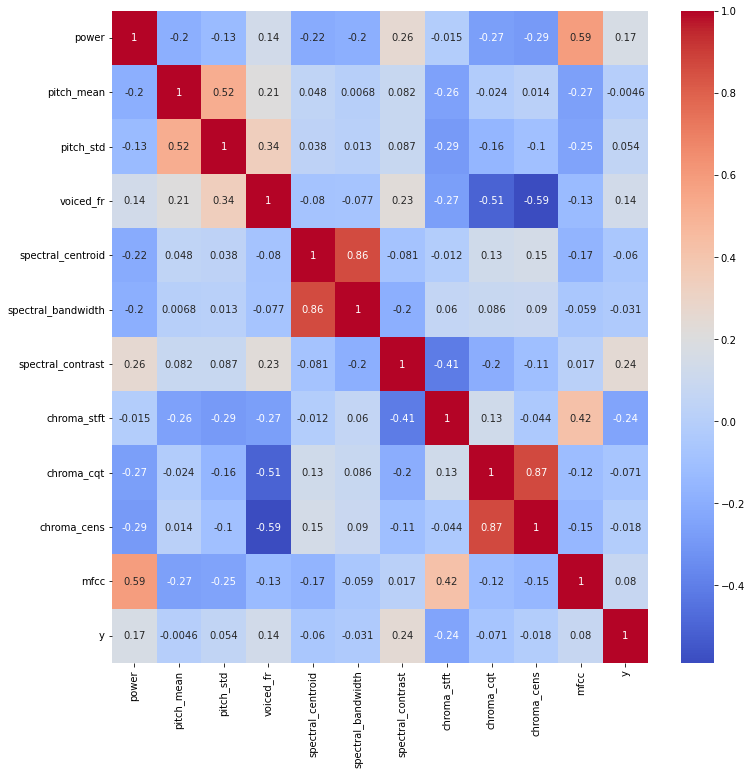

In [100]:
plt.figure(figsize=(12,12)) 
sns.heatmap(arr.corr(),annot=True,cmap='coolwarm') 
plt.show()

We can observe some strong correlation between features like mfcc and power. Also, the label y is weakly correlated with the features extracted from the audio dataset.

# 9 Modeling
We use following models to predict the area where a given audio segment is captured.

1. Random Forest  <br>
2. KNN <br>

Reasons for chosing Random Forest <br>
1. Performs well in large data sets <br>
2. Accuracy is reasonably high <br>
3. Overfitting can be avoided despite many features <br>
Reasons for chosing KNN <br>
1. Relatively inexpensive computationally <br>
2. No need to iterate tuning parameters<br>
3. Easy to Implement<br>

Splitting processed data into training and validation sets.

In [69]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1745, 11), (749, 11), (1745,), (749,))

<h1>Random Forest</h1>

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'n_estimators':[200,300,400],
    'bootstrap': ['False'],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = RandomForestClassifier()
grid_forest = GridSearchCV(grid_rf, parameters, n_jobs=-1)

grid_forest.fit(X_train,y_train)

yt_p = grid_forest.predict(X_train)
yv_p = grid_forest.predict(X_val)


In [71]:
#optimal model parameters
print (grid_forest.best_score_)
print (grid_forest.best_params_)
     

0.436676217765043
{'bootstrap': 'False', 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 300}


In [72]:
#We now run the best classifer
clf_1 = RandomForestClassifier(max_depth=8,  criterion='entropy', n_estimators=200, bootstrap=False, class_weight='balanced',n_jobs=-1)
clf_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=8, n_estimators=200,
                       n_jobs=-1)

In [73]:
yt_p = clf_1.predict(X_train)
yv_p = clf_1.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.8567335243553008
Validation  Accuracy 0.3684913217623498


In [42]:
model  = svm.SVC(C=5)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.6154727793696275
Validation  Accuracy 0.4325767690253672
The support vectors are (1604, 11)


In [43]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9753581661891118
Validation  Accuracy 0.3364485981308411
The support vectors are (1745, 11)


<h1>KNN</h1>

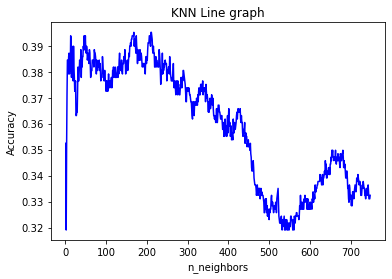

Training Accuracy 0.5318051575931232
Validation  Accuracy 0.38584779706275035


In [104]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
index = range(1, len(X_val))
for i in range(1, len(X_val)):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_val, y_val))
plt.title("KNN Line graph")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.plot(index, scores, color="blue")
plt.ion()
plt.show()
plt.pause(2)
plt.close()


knn_model = KNeighborsClassifier(n_neighbors = 8)
knn_model.fit(X_train, y_train)

yt_p_knn = knn_model.predict(X_train)
yv_p_knn = knn_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p_knn==y_train))
print('Validation  Accuracy', np.mean(yv_p_knn==y_val))


# 10 Performance Evaluation and Results

We use Precision, Recall, F1-Score, Support, Confusion Matrix and ROC AUC score to analyze and evaluate the two models that we have used. 

Precision, Recall, F1-Score, Support and Confusion Matrix for Random Forest Classifier

              precision    recall  f1-score   support

      Euston       0.22      0.37      0.27        75
     british       0.27      0.30      0.28       132
      campus       0.55      0.41      0.47       238
  kensington       0.29      0.39      0.33        49
   southbank       0.16      0.14      0.15        63
     westend       0.47      0.44      0.45       192

    accuracy                           0.37       749
   macro avg       0.33      0.34      0.33       749
weighted avg       0.40      0.37      0.38       749



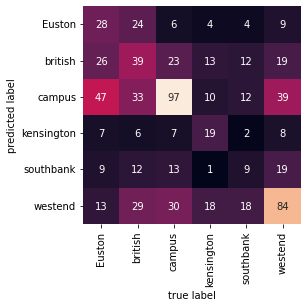

In [108]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

x = metrics.confusion_matrix(y_val, yv_p, labels=['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend'])
y = metrics.confusion_matrix(y_train, yt_p, labels=['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend'])
tones = ['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend']
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')
print(classification_report(y_val, yv_p))
          


plt.show()

Precision, Recall, F1-Score, Support and Confusion Matrix for KNN Classifier

              precision    recall  f1-score   support

      Euston       0.22      0.37      0.27        75
     british       0.27      0.30      0.28       132
      campus       0.55      0.41      0.47       238
  kensington       0.29      0.39      0.33        49
   southbank       0.16      0.14      0.15        63
     westend       0.47      0.44      0.45       192

    accuracy                           0.37       749
   macro avg       0.33      0.34      0.33       749
weighted avg       0.40      0.37      0.38       749



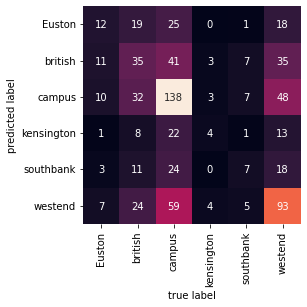

In [112]:
x = metrics.confusion_matrix(y_val, yv_p_knn, labels=['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend'])
y = metrics.confusion_matrix(y_train, yt_p_knn, labels=['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend'])
tones = ['Euston', 'british', 'campus', 'kensington', 'southbank', 'westend']
sns.heatmap(x,square=True, annot=True, fmt='d', cbar=False,
            xticklabels = tones,
            yticklabels = tones)
plt.xlabel('true label')
plt.ylabel('predicted label')
print(classification_report(y_val, yv_p))


ROC curve allows us to visualize the tradeoff between true positive rate (TPR) and false positive rate (FPR). ROC AUC essentially is computing the area under the ROC curve.

In [114]:
from sklearn.metrics import roc_auc_score

# Finding probabilities for roc_auc_score
rf_probabilities = clf_1.predict_proba(X_train)

# Finding probabilities for roc_auc_score
knn_probabilities = knn_model.predict_proba(X_train)

knn_roc_auc_score = roc_auc_score(y_train, knn_probabilities, multi_class="ovr")
print("ROC accuracy Score for KNN : {:.5f} ".format(knn_roc_auc_score))

rfa_roc_auc_score = roc_auc_score(y_train, rf_probabilities, multi_class="ovr")
print("ROC accuracy Score for Random Forest Algorithm : {:.5f} ".format(rfa_roc_auc_score))

ROC accuracy Score for KNN : 0.84990 
ROC accuracy Score for Random Forest Algorithm : 0.98372 


# 11 Conclusions

In advanced solution we have compared two different classification models for predicting area where the audio segment was captured. Based on the performance evaluation of these models, we can conclude that KNN Algorithm performs better as it has better validation accuracy of 38.5 percent. The data are skewed towards certain areas. So, it is difficult, irrespective of what model we choose, to achieve a significantly high accuracy. 